#Real Phones Random Foreest

##Set up

In [1]:
use_grid_search = False

use_mean = True
use_median = False

In [2]:
# use_mean = False
# use_median = False
# choice = ''
# while choice not in ['1', '2', '3']:
#   print('1. Use mean')
#   print('2. Use median')
#   print('3. Use mode')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_mean = True
# elif choice == '2':
#   use_median = True

# choice = ''
# while choice not in ['1', '2']:
#   print('1. Use Grid Search')
#   print('2. Use Default Parameters')
#   choice = input('Enter your choice:')

# if choice == '1':
#   use_grid_search = True
# else:
#   use_grid_search = False

##Libraries

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder, LabelEncoder
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

##Importing Cleaned Dataset

In [4]:
cleaned = pd.read_csv('Cleaned smartphones.csv')

cleaned.head()

,brand_name,price,avg_rating,5G_or_not,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,ram_capacity,internal_memory,screen_size,refresh_rate,num_rear_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,resolution_height,resolution_width
0,apple,472.314400,7.3,0,bionic,6.0,2.65,3110.000000,0,4,64,6.1,60,2,ios,12.0,12.0,0,1792,828
1,apple,569.201889,7.5,0,bionic,6.0,2.65,3110.000000,0,4,128,6.1,60,2,ios,12.0,12.0,0,1792,828
2,apple,629.756570,7.4,1,bionic,6.0,3.10,4817.748194,0,4,64,6.1,60,2,ios,12.0,12.0,0,2532,1170
3,apple,678.200315,7.5,1,bionic,6.0,3.10,4817.748194,0,4,128,6.1,60,2,ios,12.0,12.0,0,2532,1170
4,apple,823.531549,7.6,1,bionic,6.0,3.10,4817.748194,0,4,256,6.1,60,2,ios,12.0,12.0,0,2532,1170


##Preparing data for modelling

###Scaling Numerical Data

In [5]:
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    continue
  if col == 'price':
    price_scaler = StandardScaler()
    cleaned[col] = price_scaler.fit_transform(cleaned[col].values.reshape(-1,1))
    continue
  scaler = StandardScaler()
  cleaned[col] = scaler.fit_transform(cleaned[col].values.reshape(-1,1))

In [6]:
cleaned.head()

,brand_name,price,avg_rating,5G_or_not,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,ram_capacity,internal_memory,screen_size,refresh_rate,num_rear_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,resolution_height,resolution_width
0,apple,1.194146,-0.693494,-1.040929,bionic,-2.169421,0.660805,-1.711367,-2.317814,-0.890621,-0.900269,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,-0.735217,-0.781904
1,apple,1.772763,-0.412994,-1.040929,bionic,-2.169421,0.660805,-1.711367,-2.317814,-0.890621,0.105245,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,-0.735217,-0.781904
2,apple,2.134398,-0.553244,0.960681,bionic,-2.169421,1.707232,-0.045916,-2.317814,-0.890621,-0.900269,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,0.759982,0.477197
3,apple,2.423706,-0.412994,0.960681,bionic,-2.169421,1.707232,-0.045916,-2.317814,-0.890621,0.105245,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,0.759982,0.477197
4,apple,3.291631,-0.272744,0.960681,bionic,-2.169421,1.707232,-0.045916,-2.317814,-0.890621,2.116273,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,0.759982,0.477197


###Encoding Strings

In [7]:
string_cols = []
for col in cleaned.columns:
  if cleaned.dtypes[col] == 'object':
    string_cols.append(col)
    print(col)

cleaned.head()

brand_name
processor_brand
os


,brand_name,price,avg_rating,5G_or_not,processor_brand,num_cores,processor_speed,battery_capacity,fast_charging_available,ram_capacity,internal_memory,screen_size,refresh_rate,num_rear_cameras,os,primary_camera_rear,primary_camera_front,extended_memory_available,resolution_height,resolution_width
0,apple,1.194146,-0.693494,-1.040929,bionic,-2.169421,0.660805,-1.711367,-2.317814,-0.890621,-0.900269,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,-0.735217,-0.781904
1,apple,1.772763,-0.412994,-1.040929,bionic,-2.169421,0.660805,-1.711367,-2.317814,-0.890621,0.105245,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,-0.735217,-0.781904
2,apple,2.134398,-0.553244,0.960681,bionic,-2.169421,1.707232,-0.045916,-2.317814,-0.890621,-0.900269,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,0.759982,0.477197
3,apple,2.423706,-0.412994,0.960681,bionic,-2.169421,1.707232,-0.045916,-2.317814,-0.890621,0.105245,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,0.759982,0.477197
4,apple,3.291631,-0.272744,0.960681,bionic,-2.169421,1.707232,-0.045916,-2.317814,-0.890621,2.116273,-1.346841,-1.091133,-0.999973,ios,-1.181535,-0.405616,-1.486458,0.759982,0.477197


In [8]:
# for col in string_cols:

  # encoder = OneHotEncoder(sparse_output=False)
  # encoder.fit(cleaned[col].values.reshape(-1,1))
  # encoded = encoder.transform(cleaned[col].values.reshape(-1,1))
  # encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]))

  # cleaned = cleaned.drop(columns=col)
  # cleaned = pd.concat([cleaned, encoded_df], axis=1)

for col in string_cols:
    encoder = TargetEncoder(target_type="continuous", random_state=42, smooth = 5)
    # encoder = LabelEncoder()
    X = cleaned[col].values.reshape(-1, 1)
    encoder.fit(X, cleaned['price'])
    # encoder.fit(cleaned[col])
    cleaned[col] = encoder.transform(X)

In [9]:
cleaned.columns

Index(['brand_name', 'price', 'avg_rating', '5G_or_not', 'processor_brand',
       'num_cores', 'processor_speed', 'battery_capacity',
       'fast_charging_available', 'ram_capacity', 'internal_memory',
       'screen_size', 'refresh_rate', 'num_rear_cameras', 'os',
       'primary_camera_rear', 'primary_camera_front',
       'extended_memory_available', 'resolution_height', 'resolution_width'],
      dtype='object')

In [10]:
cleaned.isnull().sum()

,0
brand_name,0
price,0
avg_rating,0
5G_or_not,0
processor_brand,0
num_cores,0
processor_speed,0
battery_capacity,0
fast_charging_available,0
ram_capacity,0


##Building Model

###Loading X and y

In [11]:
X = cleaned.drop('price', axis=1)
y = cleaned['price']

In [12]:
print(X.shape)
print(y.shape)

(873, 19)
(873,)


###Feature Selection

In [13]:
# sfm = SelectFromModel(RandomForestRegressor(), threshold="median")
# sfm.fit(X, y)

# X_new = sfm.transform(X)

Looking at features ranked and the ones selected.

In [14]:
# importances = sfm.estimator_.feature_importances_
# feature_scores = pd.DataFrame({
#     'Feature': X.columns,
#       'Importance': importances
# }).sort_values(by='Importance', ascending = False),

# print(feature_scores)

# # Get the indices of the selected features
# selected_feature_indices = sfm.get_support(indices=True)

# # Get the names of the selected features
# selected_feature_names = X.columns[selected_feature_indices]

# print("Selected Features:", selected_feature_names)

In [15]:
# X = X_new

###Splitting up training and testing data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(698, 19)
(175, 19)
(698,)
(175,)


###Finding best parameters

In [18]:
if use_grid_search:
  param_grid = {
      'max_depth': [50, 100, 150, 200],
      'max_features': ['sqrt', 'log2'],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4],
      'bootstrap': [False],
      'max_leaf_nodes': [50, 100, 150, 200],
      'n_estimators': [100, 150, 200, 250],
      'random_state': [42]
  }

In [19]:
if use_grid_search:
  grid_search = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, scoring='neg_mean_absolute_error', n_jobs=3, cv = 3)


In [20]:
if use_grid_search:
  grid_search.fit(X_train, y_train)

In [21]:
if use_grid_search:
  print(grid_search.best_params_)

###Building Random Forest Model

In [22]:
if use_grid_search:
  model = RandomForestRegressor(**grid_search.best_params_)
else:
  # model = RandomForestRegressor(max_depth = 50, max_features =  'sqrt', min_samples_leaf = 1, min_samples_split = 2, bootstrap= False, max_leaf_nodes=200, n_estimators = 150, random_state = 42)
  model = RandomForestRegressor(max_depth = 50, max_features =  'sqrt', min_samples_leaf = 1, min_samples_split = 2, bootstrap= False, max_leaf_nodes=200, n_estimators = 150, random_state = 42)

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      max_leaf_nodes=200, n_estimators=150, random_state=42)

##Testing Model

In [23]:
print(f'Train Accuracy: {model.score(X_train, y_train):.3f}')
print(f'Test Accuracy:  {model.score(X_test, y_test):.3f}')

Train Accuracy: 0.992
Test Accuracy:  0.872


In [24]:
# Making predictions on the test set
y_pred = model.predict(X_test)

y_pred = price_scaler.inverse_transform(y_pred.reshape(-1,1))
y_test = price_scaler.inverse_transform(y_test.values.reshape(-1,1))

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_test, y_pred):.2f}')

Mean Absolute Error: 36.76
Mean Absolute Percentage Error: 0.14


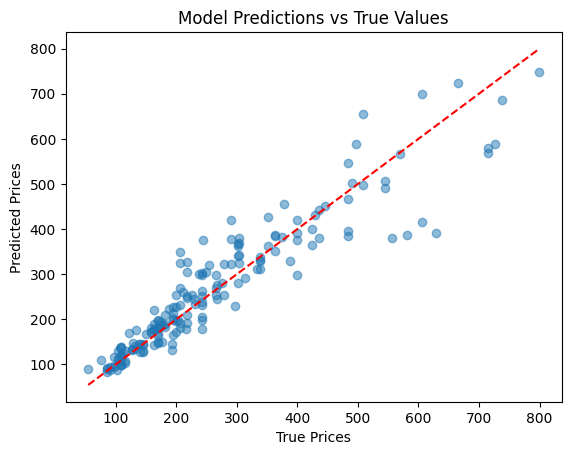

In [25]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title("Model Predictions vs True Values")
plt.show()